In [ ]:
EMBEDDING = "CRAFT"
EXPERIMENT_NO = "1"
PROJECT_NAME = "NEMOA"

In [ ]:
import json
import os
import pickle
from itertools import chain
from time import sleep


if EMBEDDING == "ELMO":
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()
    from tensorflow.keras import backend as K

    from tensorflow.compat.v1.keras.backend import set_session
    import tensorflow_hub as hub
else:
    import tensorflow as tf
from tensorflow.keras.layers import GRU, Dense, Dropout, InputLayer, Embedding, Bidirectional, TimeDistributed, Input, Concatenate, SpatialDropout1D, Reshape, Lambda
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy

import numpy as np
import pandas as pd

from gensim.models import KeyedVectors
from sklearn.metrics import classification_report

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
%%capture
!pip install wandb

import wandb
from wandb.keras import WandbCallback

In [ ]:
BASE_DIR = '/content/drive/MyDrive/Craft_4_Seq_ONER'
DATA_DIR = os.path.join(BASE_DIR, "data")
MODEL_DIR = os.path.join(BASE_DIR, "model_output", "Experiments")
OLD_DIR = '/content/drive/MyDrive/model_data/last_experiment'
GLOVE_EMB_FILE = os.path.join(BASE_DIR, "Embedding", "glove.840B.300d.bin")
DATASET_LOC = os.path.join(DATA_DIR, "model_input", "dataset")
subsumer_file = os.path.join(DATA_DIR, "GO_Category", "GO_AllSubsumers.tsv")

In [ ]:
subsumers = dict()
infile = open(subsumer_file)
for line in infile:
    child, subsumer = line.strip().split("\t")
    if child not in subsumers:
        subsumers[child] = set()
        subsumers[child].add(child)
    if subsumer != "owl:Thing":
        subsumers[child].add(subsumer)

In [ ]:
def simj(term1,term2,ancestors):
    if term1 not in ancestors:
        ancestors[term1]=set(term1)
    if term2 not in ancestors:
        ancestors[term2]=set(term2)
    if len(set.union(ancestors[term1],ancestors[term2])) >0:
        simj=len(set.intersection(ancestors[term1],ancestors[term2]))/len(set.union(ancestors[term1],ancestors[term2]))
    else:
        simj=0
    return simj

In [ ]:
def getsimj(term1, term2):
    if term1 == term2:
        return 0 if term1 == "O" else 1
    else:
        return simj(term1, term2, subsumers)

In [ ]:
RUN = "{0}_{1}".format(EMBEDDING, EXPERIMENT_NO)
config = {
    "RUN": RUN, "OPTIMIZER": "Adam", "MODEL_NAME": "GRU_{0}".format(EMBEDDING),
    "BATCH_SIZE": 16, "MIN_SENT_LEN": 3, "MAX_WORD_LEN": 71, "MAX_CHAR_LEN": 15, "EPOCHS": 300,
    "LEARNING_RATE": 0.001, "PAD_CHAR": "@", "EARLY_STOPPING": True, "RECURRENT_DROPOUT": False,
    "DROPOUT": 0.1, "EMBEDDING": EMBEDDING, "IGNORE_PAD_LOSS": True, "ONE_HOT_ENCODING": False,
     "OPTIMIZED_CLASS_WEIGHT": True, "REDUCE_LR_ON_PLATEAU": True, "PROJECT_NAME": PROJECT_NAME
}
config.update({
    "INPUT_LAYERS": {
        'tokens': True,
        'characters': True,
        'encodings': True,
        'iob_tags': True,
        'pos_tags': True,
        'protein_terms': True,
        'biomedical_terms': True,
        'chemical_terms': False,
        'macromolecule_terms': False,        
        'umls_terms': False
        }})
emb = config.get("EMBEDDING").upper()
emb_dim = 1024
if emb == "CRAFT":
    emb_dim = 100
elif emb == "GLOVE":
    emb_dim = 300
elif emb == "ELMO":
    config.update({"ONE_HOT_ENCODING": True,
                   "IGNORE_PAD_LOSS": False,
                   "OPTIMIZED_CLASS_WEIGHT": False
                   })
config.update({"EMBEDDING_DIM": emb_dim})
config.update(config.get("INPUT_LAYERS"))
OPTIMIZER = Adam(learning_rate=config.get("LEARNING_RATE", 0.001))

In [ ]:
temp_config = dict((k, v) for k, v in config.items() if k != "INPUT_LAYERS")
wb_run = wandb.init(project=config.get("PROJECT_NAME"), config=temp_config, name=config["RUN"], reinit=True)

wandb: Currently logged in as: p_devkota (use `wandb login --relogin` to force relogin)


In [ ]:
test_data = json.load(open(os.path.join(DATASET_LOC, "test.json"), "r"))

if config.get('augmentation'):
    train_data = json.load(open(os.path.join(DATASET_LOC, "train_augmented.json"), "r"))
else:
    train_data = json.load(open(os.path.join(DATASET_LOC, "train.json"), "r"))

train_data = [i for i in train_data if len(i['tokens']) >= config['MIN_SENT_LEN']]
train_data = train_data[:len(train_data)//config.get("BATCH_SIZE")*config.get("BATCH_SIZE")]

test_data = [i for i in test_data if len(i['tokens']) >= config['MIN_SENT_LEN']]
test_data = test_data[:len(test_data)//config.get("BATCH_SIZE")*config.get("BATCH_SIZE")]

prep_data = wandb.Artifact("pre_train", type="dataset",
        description="Training data imported from source",
        metadata={"source": DATASET_LOC,
                  "augmented": True if config.get('augmentation') else False,
                  "size": len(train_data)})
with prep_data.new_file("train_dataset.json", "w") as file:
    json.dump(train_data, file)
wb_run.log_artifact(prep_data)

prep_data = wandb.Artifact("pre_test", type="dataset",
        description="Test data imported from source",
        metadata={"source": DATASET_LOC,
                  "augmented": True if config.get('augmentation') else False,
                  "size": len(test_data)})
with prep_data.new_file("test_dataset.json", "w") as file:
    json.dump(test_data, file)
wb_run.log_artifact(prep_data)

In [ ]:
################################## TOKENS ######################################
if config.get("tokens"):
    all_words = [j for i in train_data + test_data for j in i['tokens']]
    unique_words = sorted(list(set(all_words)))

    word2idx = {**{config.get("PAD_CHAR"): 0}, **{w: i for i, w in enumerate(unique_words, 1)}}
    idx2word = {i: w for w, i in word2idx.items()}
    n_words = len(unique_words) + 1

################################ CHARACTERS ####################################
if config.get("characters"):
    all_chars = [j for i in all_words for j in i]
    unique_chars = sorted(list(set(all_chars)))

    char2idx = {**{config.get("PAD_CHAR"): 0}, **{c: i for i, c in enumerate(unique_chars, 1)}}
    n_chars = len(unique_chars) + 1

################################# ENCODINGS ####################################
if config.get("encodings"):
    all_char_encs = [j for i in train_data + test_data for j in i['encodings']]
    unique_char_encs = sorted(list(set(all_char_encs)))

    charenc2idx = {**{config.get("PAD_CHAR"): 0}, **{c: i for i, c in enumerate(unique_char_encs, 1)}}
    n_char_encs = len(unique_char_encs) + 1

################################# POS TAGS #####################################
if config.get("pos_tags"):
    all_pos = [j for i in train_data + test_data for j in i['pos_tags']]
    unique_pos = sorted(list(set(all_pos)))

    pos2idx = {**{config.get("PAD_CHAR"): 0}, **{p: i for i, p in enumerate(unique_pos, 1)}}
    n_pos = len(unique_pos) + 1

################################# IOB TAGS #####################################
if config.get("iob_tags"):
    all_tags = [j for i in train_data + test_data for j in i['iob_tags']]
    unique_tags = sorted(list(set(all_tags)))

    tag2idx = {**{config.get("PAD_CHAR"): 0}, **{t: i for i, t in enumerate(unique_tags, 1)}}
    idx2tag = {i: t for t, i in tag2idx.items()}
    n_tags = len(unique_tags) + 1

In [ ]:
X_train, X_test = [], []

# ------------------------------------------------------------------------------
if config.get("tokens"):
    if config.get("EMBEDDING") == "ELMO":
        token_train = [(i['tokens'], len(i['tokens'])) for i in train_data]
        X_token_train = [i[0][:config.get("MAX_WORD_LEN")] + [""]*(config.get("MAX_WORD_LEN")-i[1]) for i in token_train]
        X_train.append(np.array(X_token_train))

        token_test = [(i['tokens'], len(i['tokens'])) for i in test_data]
        X_token_test = [i[0][:config.get("MAX_WORD_LEN")] + [""]*(config.get("MAX_WORD_LEN")-i[1]) for i in token_test]
        X_test.append(np.array(X_token_test))
    else:
        X_token_train = [list(map(word2idx.get, i['tokens'])) for i in train_data]
        X_token_train = pad_sequences(maxlen=config.get("MAX_WORD_LEN"), sequences=X_token_train, padding='post', value=word2idx[config.get("PAD_CHAR")], truncating='post')
        X_train.append(X_token_train)

        X_token_test = [list(map(word2idx.get, i['tokens'])) for i in test_data]
        X_token_test = pad_sequences(maxlen=config.get("MAX_WORD_LEN"), sequences=X_token_test, padding='post', value=word2idx[config.get("PAD_CHAR")], truncating='post')
        X_test.append(X_token_test)

# ------------------------------------------------------------------------------
if config.get("characters"):
    X_char_train = [[list(map(char2idx.get, (j[:config.get("MAX_CHAR_LEN")] + config.get("PAD_CHAR") * (config.get("MAX_CHAR_LEN") - len(j))))) for j in (i['tokens'] + [config.get("PAD_CHAR")*config.get("MAX_CHAR_LEN")]*(config.get("MAX_WORD_LEN") - len(i['tokens'])))] for i in train_data]
    X_char_train = pad_sequences(maxlen=config.get("MAX_WORD_LEN"), sequences=X_char_train, padding='post', value=[char2idx[config.get("PAD_CHAR")]]*config.get("MAX_CHAR_LEN"), truncating='post')
    X_train.append(X_char_train)

    X_char_test = [[list(map(char2idx.get, (j[:config.get("MAX_CHAR_LEN")] + config.get("PAD_CHAR") * (config.get("MAX_CHAR_LEN") - len(j))))) for j in (i['tokens'] + [config.get("PAD_CHAR")*config.get("MAX_CHAR_LEN")]*(config.get("MAX_WORD_LEN") - len(i['tokens'])))] for i in test_data]
    X_char_test = pad_sequences(maxlen=config.get("MAX_WORD_LEN"), sequences=X_char_test, padding='post', value=[char2idx[config.get("PAD_CHAR")]]*config.get("MAX_CHAR_LEN"), truncating='post')
    X_test.append(X_char_test)

# ------------------------------------------------------------------------------
if config.get("encodings"):
    X_char_enc_train = [list(map(charenc2idx.get, i['encodings'])) for i in train_data]
    X_char_enc_train = pad_sequences(maxlen=config.get("MAX_WORD_LEN"), sequences=X_char_enc_train, padding='post', value=charenc2idx[config.get("PAD_CHAR")], truncating='post')
    # X_char_enc_train = np.expand_dims(X_char_enc_train, axis=-1)
    X_train.append(X_char_enc_train)

    X_char_enc_test = [list(map(charenc2idx.get, i['encodings'])) for i in test_data]
    X_char_enc_test = pad_sequences(maxlen=config.get("MAX_WORD_LEN"), sequences=X_char_enc_test, padding='post', value=charenc2idx[config.get("PAD_CHAR")], truncating='post')
    # X_char_enc_test = np.expand_dims(X_char_enc_test, axis=-1)
    X_test.append(X_char_enc_test)

# ------------------------------------------------------------------------------
if config.get("pos_tags"):
    X_pos_train = [list(map(pos2idx.get, i['pos_tags'])) for i in train_data]
    X_pos_train = pad_sequences(maxlen=config.get("MAX_WORD_LEN"), sequences=X_pos_train, padding='post', value=pos2idx[config.get("PAD_CHAR")], truncating='post')
    # X_pos_train = np.expand_dims(X_pos_train, axis=-1)
    X_train.append(X_pos_train)

    X_pos_test = [list(map(pos2idx.get, i['pos_tags'])) for i in test_data]
    X_pos_test = pad_sequences(maxlen=config.get("MAX_WORD_LEN"), sequences=X_pos_test, padding='post', value=pos2idx[config.get("PAD_CHAR")], truncating='post')
    # X_pos_test = np.expand_dims(X_pos_test, axis=-1)
    X_test.append(X_pos_test)
# ------------------------------------------------------------------------------
if config.get("protein_terms"):
    X_protein_train = [i['protein_terms'] for i in train_data]
    X_protein_train = pad_sequences(maxlen=config.get("MAX_WORD_LEN"), sequences=X_protein_train, padding='post', value=0, truncating='post')
    X_protein_train = np.expand_dims(X_protein_train, axis=-1)
    X_train.append(X_protein_train)

    X_protein_test = [i['protein_terms'] for i in test_data]
    X_protein_test = pad_sequences(maxlen=config.get("MAX_WORD_LEN"), sequences=X_protein_test, padding='post', value=0, truncating='post')
    X_protein_test = np.expand_dims(X_protein_test, axis=-1)
    X_test.append(X_protein_test)
# ------------------------------------------------------------------------------
if config.get("biomedical_terms"):
    X_bio_train = [i['biomedical_terms'] for i in train_data]
    X_bio_train = pad_sequences(maxlen=config.get("MAX_WORD_LEN"), sequences=X_bio_train, padding='post', value=0, truncating='post')
    X_bio_train = np.expand_dims(X_bio_train, axis=-1)
    X_train.append(X_bio_train)

    X_bio_test = [i['biomedical_terms'] for i in test_data]
    X_bio_test = pad_sequences(maxlen=config.get("MAX_WORD_LEN"), sequences=X_bio_test, padding='post', value=0, truncating='post')
    X_bio_test = np.expand_dims(X_bio_test, axis=-1)
    X_test.append(X_bio_test)
# ------------------------------------------------------------------------------
if config.get("chemical_terms"):
    X_chem_train = [i['chemical_terms'] for i in train_data]
    X_chem_train = pad_sequences(maxlen=config.get("MAX_WORD_LEN"), sequences=X_chem_train, padding='post', value=0, truncating='post')
    X_chem_train = np.expand_dims(X_chem_train, axis=-1)
    X_train.append(X_chem_train)

    X_chem_test = [i['chemical_terms'] for i in test_data]
    X_chem_test = pad_sequences(maxlen=config.get("MAX_WORD_LEN"), sequences=X_chem_test, padding='post', value=0, truncating='post')
    X_chem_test = np.expand_dims(X_chem_test, axis=-1)
    X_test.append(X_chem_test)
# ------------------------------------------------------------------------------
if config.get("macromolecule_terms"):
    X_macro_train = [i['macromolecule_terms'] for i in train_data]
    X_macro_train = pad_sequences(maxlen=config.get("MAX_WORD_LEN"), sequences=X_macro_train, padding='post', value=0, truncating='post')
    X_macro_train = np.expand_dims(X_macro_train, axis=-1)
    X_train.append(X_macro_train)

    X_macro_test = [i['macromolecule_terms'] for i in test_data]
    X_macro_test = pad_sequences(maxlen=config.get("MAX_WORD_LEN"), sequences=X_macro_test, padding='post', value=0, truncating='post')
    X_macro_test = np.expand_dims(X_macro_test, axis=-1)
    X_test.append(X_macro_test)
# ------------------------------------------------------------------------------
if config.get("umls_terms"):
    X_umls_train = [i['umls_terms'] for i in train_data]
    X_umls_train = pad_sequences(maxlen=config.get("MAX_WORD_LEN"), sequences=X_umls_train, padding='post', value=0, truncating='post')
    X_umls_train = np.expand_dims(X_umls_train, axis=-1)
    X_train.append(X_umls_train)

    X_umls_test = [i['umls_terms'] for i in test_data]
    X_umls_test = pad_sequences(maxlen=config.get("MAX_WORD_LEN"), sequences=X_umls_test, padding='post', value=0, truncating='post')
    X_umls_test = np.expand_dims(X_umls_test, axis=-1)
    X_test.append(X_umls_test)

# ------------------------------------------------------------------------------
if config.get("iob_tags"):
    Y_train = [list(map(tag2idx.get, i['iob_tags'])) for i in train_data]
    Y_train = pad_sequences(maxlen=config.get("MAX_WORD_LEN"), sequences=Y_train, padding='post', value=tag2idx[config.get("PAD_CHAR")], truncating='post')
    
    Y_test = [list(map(tag2idx.get, i['iob_tags'])) for i in test_data]
    Y_test = pad_sequences(maxlen=config.get("MAX_WORD_LEN"), sequences=Y_test, padding='post', value=tag2idx[config.get("PAD_CHAR")], truncating='post')

    if config.get("ONE_HOT_ENCODING"):
        Y_train = to_categorical(Y_train, num_classes=n_tags)
        Y_test = to_categorical(Y_test, num_classes=n_tags)

    if Y_train.ndim == 2:
        LOSS_FUNCTION = SparseCategoricalCrossentropy()
        config.update({"LOSS_FUNCTION": "SparseCategoricalCrossentropy"})
    else:
        LOSS_FUNCTION = CategoricalCrossentropy()
        config.update({"LOSS_FUNCTION": "CategoricalCrossentropy"})

try:
    prep_data = wandb.Artifact("train_dataset", type="dataset",
                           description="Preprocessed train_dataset ready for model training",
                           metadata={"source": "WANDB_ONER",
                                     "pipelines": [k for k, v in config.get("INPUT_LAYERS").items() if v],
                                     "# pipelines": len(X_train),
                                     "shape": {"X_train": "(" + ", ".join(str(i) for i in X_train[0].shape) + ")", 
                                               "Y_train": "(" + ", ".join(str(i) for i in Y_train.shape) + ")"},
                                     "save_Y": False if Y_train.ndim == 3 else True})
    with prep_data.new_file("train.pkl", "wb") as file:
        pickle.dump({"X_train": X_train, "Y_train": Y_train if Y_train.ndim ==2 else np.argmax(Y_train)}, file)
    wb_run.log_artifact(prep_data)
except Exception as ex:
    pass

try:
    prep_data = wandb.Artifact("test_dataset", type="dataset",
                           description="Preprocessed test_dataset ready for model testing",
                           metadata={"source": "WANDB_ONER",
                                     "pipelines": [k for k, v in config.get("INPUT_LAYERS").items() if v],
                                     "# pipelines": len(X_test),
                                     "shape": {"X_test": "(" + ", ".join(str(i) for i in X_test[0].shape) + ")", 
                                               "Y_test": "(" + ", ".join(str(i) for i in Y_test.shape) + ")"},
                                     "save_Y": False if Y_train.ndim == 3 else True})


    with prep_data.new_file("test.pkl", "wb") as file:
        pickle.dump({"X_test": X_test, "Y_test": Y_test if Y_test.ndim ==2 else np.argmax(Y_test)}, file)
    wb_run.log_artifact(prep_data)
except Exception as ex:
    pass

In [ ]:
X_train[0].shape, X_test[0].shape, Y_train.shape, Y_test.shape

((23104, 71), (5760, 71), (23104, 71, 1774), (5760, 71, 1774))

In [ ]:
if config.get("EMBEDDING") == "GLOVE":
    word2vec = KeyedVectors.load_word2vec_format(GLOVE_EMB_FILE, binary=True)
    w2v_vocab, w2v_vector = word2vec.vocab, word2vec.vectors
    embeddings_index = dict((vocab, vector) for vocab, vector in zip(w2v_vocab, w2v_vector))
    emb_matrix = np.zeros((n_words, config.get("EMBEDDING_DIM")))
    hits, misses = 0, 0
    for word, index in word2idx.items():
        vec = embeddings_index.get(word)
        if vec is not None:
            emb_matrix[index] = vec
            hits += 1
        else:
            misses += 1
    print("Total hit: {0}\nTotal miss: {1}".format(hits, misses))
    config.update({"EMBEDDING_DIM": w2v_vector[0].size})
elif config.get("EMBEDDING") == "ELMO":
    def ElmoEmbedding(x):
        return elmo_model(inputs={
                                "tokens": tf.squeeze(tf.cast(x, tf.string)),
                                "sequence_len": tf.cast(tf.count_nonzero(x, axis=1), dtype=tf.int32) #tf.constant(BATCH_SIZE*[MAX_WORD_LEN])
                          },
                          signature="tokens",
                          as_dict=True)["elmo"]
    

    sess = tf.Session()
    set_session(sess)
    elmo_model = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())

In [ ]:
concat_inputs, inputs = [], []

# ------------------------------------------------------------------------------
if config.get("tokens"):
    tokens_input = Input(shape=config.get("MAX_WORD_LEN"), name="TOKENS_INPUT", batch_size=config.get("BATCH_SIZE", 16))
    if config.get("EMBEDDING") == "GLOVE":
        tokens_emb = Embedding(input_dim=n_words, output_dim=config.get("EMBEDDING_DIM"), embeddings_initializer=tf.keras.initializers.Constant(emb_matrix),
                              input_length=config.get("MAX_WORD_LEN"), trainable=True, name="GLOVE_EMBEDDING")(tokens_input)
    elif config.get("EMBEDDING") == "ELMO":
        tokens_input = Input(shape=config.get("MAX_WORD_LEN"), name="TOKENS_INPUT", dtype=tf.string, batch_size=config.get("BATCH_SIZE", 16))
        tokens_emb = Lambda(ElmoEmbedding, name="ELMO_EMBEDDING")(tokens_input)
    else:
        tokens_emb = Embedding(input_dim=n_words, output_dim=100, input_length=config.get("MAX_WORD_LEN"), mask_zero=True, 
                               name="CRAFT_EMBEDDING")(tokens_input)
    concat_inputs.append(tokens_emb)
    inputs.append(tokens_input)

# ------------------------------------------------------------------------------
if config.get("characters"):
    char_input = Input(shape=(config.get("MAX_WORD_LEN"), config.get("MAX_CHAR_LEN"),), name="CHARACTER_INPUT", batch_size=config.get("BATCH_SIZE", 16))
    char_emb = TimeDistributed(Embedding(input_dim=n_chars, output_dim=100, input_length=config.get("MAX_CHAR_LEN"), mask_zero=True))(char_input)
    if config.get("RECURRENT_DROPOUT", None):
        char_emb = TimeDistributed(GRU(units=150, return_sequences=False, recurrent_dropout=0.6))(char_emb)
    else:
        char_emb = TimeDistributed(GRU(units=150, return_sequences=False, dropout=0.6))(char_emb)
    concat_inputs.append(char_emb)
    inputs.append(char_input)

# ------------------------------------------------------------------------------
if config.get("encodings"):
    char_enc_input = Input(shape=config.get("MAX_WORD_LEN"), name="ENCODINGS_INPUT", batch_size=config.get("BATCH_SIZE", 16))
    charenc_emb = Embedding(input_dim=n_char_encs, output_dim=100, input_length=config.get("MAX_WORD_LEN"), mask_zero=True, name="CHARENC_EMBEDDING_LAYER")(char_enc_input)
    concat_inputs.append(charenc_emb)
    inputs.append(char_enc_input)

# ------------------------------------------------------------------------------
if config.get("pos_tags"):
    pos_input = Input(shape=config.get("MAX_WORD_LEN"), name="POS_INPUT", batch_size=config.get("BATCH_SIZE", 16))
    pos_emb = Embedding(input_dim=n_pos, output_dim=100, input_length=config.get("MAX_WORD_LEN"), mask_zero=True, name="POS_EMBEDDING_LAYER")(pos_input)
    concat_inputs.append(pos_emb)
    inputs.append(pos_input)

# ------------------------------------------------------------------------------
if config.get("protein_terms"):
    protein_input = Input(shape=(config.get("MAX_WORD_LEN"), 1, ), name='PROTEIN_INPUT', batch_size=config.get("BATCH_SIZE", 16))
    concat_inputs.append(protein_input)
    inputs.append(protein_input)

if config.get("biomedical_terms"):
    biomedical_input = Input(shape=(config.get("MAX_WORD_LEN"), 1, ), name='BIOMEDICAL_INPUT', batch_size=config.get("BATCH_SIZE", 16))
    concat_inputs.append(biomedical_input)
    inputs.append(biomedical_input)

if config.get("chemical_terms"):
    chemical_input = Input(shape=(config.get("MAX_WORD_LEN"), 1, ), name='CHEMICAL_INPUT', batch_size=config.get("BATCH_SIZE", 16))
    concat_inputs.append(chemical_input)
    inputs.append(chemical_input)
    
if config.get("macromolecule_terms"):
    macromolecule_input = Input(shape=(config.get("MAX_WORD_LEN"), 1, ), name='MACROMOLECULE_INPUT', batch_size=config.get("BATCH_SIZE", 16))
    concat_inputs.append(macromolecule_input)
    inputs.append(macromolecule_input)

# ------------------------------------------------------------------------------
if config.get("umls_terms"):
    umls_input = Input(shape=(config.get("MAX_WORD_LEN"), 1, ), name='UMLS_INPUT', batch_size=config.get("BATCH_SIZE", 16))
    concat_inputs.append(umls_input)
    inputs.append(umls_input)

combined_input = Concatenate(name="CONCATENATE")(concat_inputs)
dropout = SpatialDropout1D(0.3, name="SPATIAL_DROPOUT")(combined_input)
if config.get("RECURRENT_DROPOUT"):
    bi_gru = Bidirectional(GRU(units=150, return_sequences=True, recurrent_dropout=config.get("DROPOUT", 0)), name="BIDIRECTIONAL_GRU")(dropout)
else:
    bi_gru = Bidirectional(GRU(units=150, return_sequences=True, dropout=config.get("DROPOUT", 0)), name="BIDIRECTIONAL_GRU")(dropout)
output = TimeDistributed(Dense(n_tags, activation='sigmoid'), name="TIME_DISTRIBUTED_LAYER")(bi_gru)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "ONER_FINAL_ELMO_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 CHARACTER_INPUT (InputLayer)   [(16, 71, 15)]       0           []                               
                                                                                                  
 TOKENS_INPUT (InputLayer)      [(16, 71)]           0           []                               
                                                                                                  
 time_distributed (TimeDistribu  (16, 71, 15, 100)   15700       ['CHARACTER_INPUT[0][0]']        
 ted)                                                                                             
                                                                                                  
 ENCODINGS_INPUT (InputLayer)   [(16, 71)]           0           []               

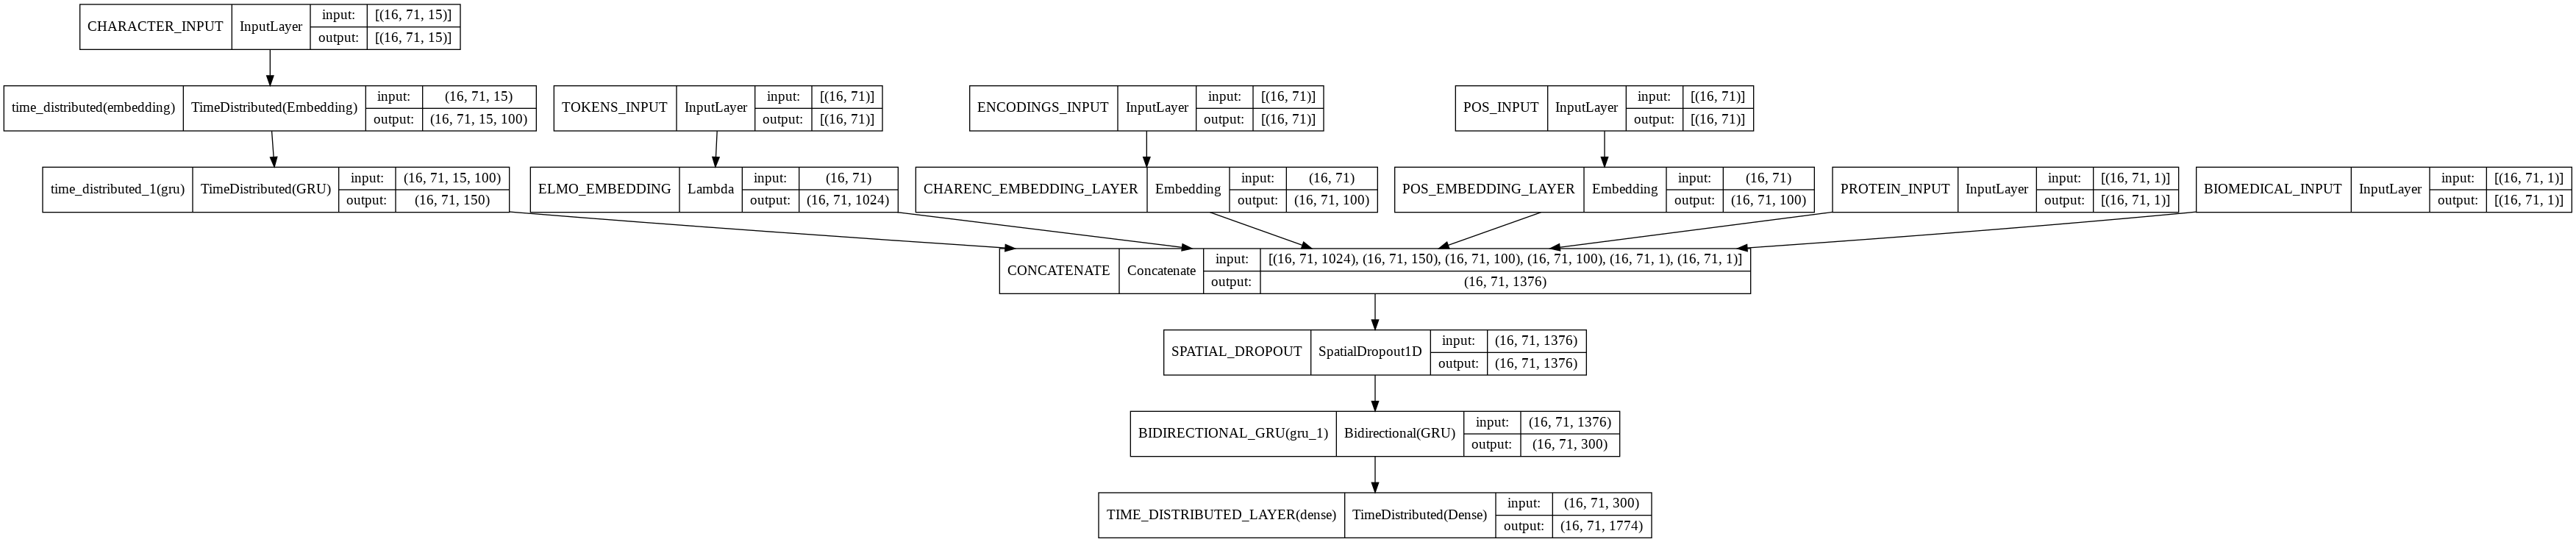

In [ ]:
model = Model(inputs, output, name=config.get("PROJECT_NAME") + "_" + config.get("RUN"))
model.compile(optimizer=OPTIMIZER, loss=globals()[config.get("LOSS_FUNCTION")](), metrics=['accuracy'])
print(model.summary())
model_arch = tf.keras.utils.plot_model(model, show_shapes=True)
display(model_arch)

In [ ]:
if config.get("OPTIMIZED_CLASS_WEIGHT"):
    tags = list(j for i in train_data+test_data for j in i['iob_tags']) + [config.get("PAD_CHAR")]
    unique_tags = set(tags)
    total_count = {}
    for i in unique_tags:
        total_count.update({i: tags.count(i)})

    total = len(tags)
    class_weights = {}
    for k, v in total_count.items():
        class_weights.update({tag2idx[k]: np.log((1 / v) * (total / 2.0))})
else:
    class_weights = None

if config.get("REDUCE_LR_ON_PLATEAU"):
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=4,
        verbose=1,
        min_lr=0.000001,
        mode='auto',
        cooldown=0,
        min_delta=0.0001
    )
    CALLBACKS = [reduce_lr]
else:
    CALLBACKS = []

if config.get("EARLY_STOPPING"):
    CALLBACKS += [EarlyStopping(
        monitor='val_loss',
        min_delta=0.0001,
        patience=10,
        verbose=1,
        mode='min',
        baseline=None,
        restore_best_weights=False
    )]
if config.get("WANDB", None):
    CALLBACKS += [WandbCallback()]

In [ ]:
history = model.fit(
    X_train, Y_train, 
    batch_size=config.get("BATCH_SIZE"),
    epochs=config.get("EPOCHS"),
    validation_data=(X_test, Y_test),
    class_weight = class_weights,
    verbose=1,
    callbacks=CALLBACKS,
)

Train on 23104 samples, validate on 5760 samples
Epoch 1/300
23104/23104 [==============================] - ETA: 0s - loss: 0.1624 - acc: 0.9422

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


23104/23104 [==============================] - 407s 18ms/sample - loss: 0.1624 - acc: 0.9422 - val_loss: 0.0944 - val_acc: 0.9704 - lr: 0.0010
Epoch 2/300
23104/23104 [==============================] - 397s 17ms/sample - loss: 0.0773 - acc: 0.9733 - val_loss: 0.0555 - val_acc: 0.9795 - lr: 0.0010
Epoch 3/300
23104/23104 [==============================] - 397s 17ms/sample - loss: 0.0453 - acc: 0.9812 - val_loss: 0.0379 - val_acc: 0.9856 - lr: 0.0010
Epoch 4/300
23104/23104 [==============================] - 401s 17ms/sample - loss: 0.0293 - acc: 0.9857 - val_loss: 0.0297 - val_acc: 0.9880 - lr: 0.0010
Epoch 5/300
23104/23104 [==============================] - 409s 18ms/sample - loss: 0.0199 - acc: 0.9888 - val_loss: 0.0261 - val_acc: 0.9896 - lr: 0.0010
Epoch 6/300
23104/23104 [==============================] - 399s 17ms/sample - loss: 0.0139 - acc: 0.9912 - val_loss: 0.0239 - val_acc: 0.9907 - lr: 0.0010
Epoch 7/300
23104/23104 [==============================] - 405s 18ms/sample - loss

In [ ]:
predicted = model.predict(X_test)
predicted = np.argsort(predicted*-1, axis=-1)[:,:,:5]

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
top_n_scores = [1, 2, 3, 5]
report_summary = {}

for top_n in top_n_scores:
    ground_truth, prediction, prediction_n, word = [], [], [], []
    for i in range(len(predicted)):
        word.append(X_test[0][i])
        if Y_train.ndim == 2:
            true_vec = Y_test[i]
        else:
            true_vec = np.argmax(Y_test[i], axis=-1)
        ground_truth.append(true_vec)
        pred_vec = predicted[i][:,:top_n]
        temp = []
        for x, y in zip(true_vec, pred_vec):
            if x in y:
                temp.append(x)
            else:
                temp.append(y[0])
        prediction.append(np.array(temp, dtype='int32'))
        prediction_n.append(pred_vec.tolist())
    t = [list(map(idx2tag.get, i)) for i in ground_truth]
    sent_len = [i.index("EOS")+1 if "EOS" in i else config.get("MAX_WORD_LEN") + 1 for i in t]
    t = [i[:sent_len[idx]] for idx, i in enumerate(t)]
    wd = [i[:sent_len[idx]] for idx, i in enumerate(word)]
    p = [list(map(idx2tag.get, i[:sent_len[idx]])) for idx, i in enumerate(prediction)]
    p_n = [[list(map(idx2tag.get, j)) for j in i[:sent_len[idx]]] for idx, i in enumerate(prediction_n)]
    report = classification_report(list(chain.from_iterable(t)), list(chain.from_iterable(p)), zero_division=False)
    pd_data = pd.DataFrame(
        {
            'Ground_Truth': list(chain.from_iterable(t)),
            'Prediction': list(chain.from_iterable(p)),
            'Prediction_n': list(chain.from_iterable(p_n)),
            'Word': list(chain.from_iterable(wd)),
        }
    )

    df1 = pd_data[(pd_data['Word'] != config.get("PAD_CHAR")) & (pd_data['Ground_Truth'] != "EOS")].copy()
    df1 = df1[(df1['Prediction'] != 'O') & (df1['Ground_Truth'] != 'O') | 
            (df1['Prediction'] == 'O') & (df1['Ground_Truth'] != 'O') |
            (df1['Prediction'] != 'O') & (df1['Ground_Truth'] == 'O')
            ]
    df2 = df1.copy()
    df2['GO_Prediction'] = df2['Prediction'].apply(lambda x: x[2:] if "GO:" in x else x)
    df2['GO_Ground_Truth'] = df2['Ground_Truth'].apply(lambda x: x[2:] if "GO:" in x else x)
    report = classification_report(df2['GO_Ground_Truth'], df2['GO_Prediction'], zero_division=False)
        
    report_summary.update({"top_{0}".format(top_n): dict((k, v) for k, v in 
                                                         zip(report.split("\n")[0].split(), report.split("\n")[-2].split()[2:]))})
    
    if top_n == 1:
        go_category = json.load(open(os.path.join(DATA_DIR, "GO_Category/go_category.json"), "r"))
        for k, v in go_category.items():
            temp = df2[(df2['GO_Prediction'].isin(v)) | (df2['GO_Ground_Truth'].isin(v))]
            wb_run.config.update({
                "F1_" + k: classification_report(temp['GO_Ground_Truth'], temp['GO_Prediction'], zero_division=False).splitlines()[-1].split()[-2]})
        wb_run.config.update({"MEAN_SEMANTIC_SIMILARITY": np.round(df2[['GO_Prediction','GO_Ground_Truth']].apply(lambda x: getsimj(x[0], x[1]), axis=1).mean(), 6)})  
for k, v in report_summary.items():
    print(k, ":", v)
wb_run.config.update(dict(("F1_TOP_" + k.split("_")[-1], v['f1-score']) for k, v in report_summary.items()))

top_1 : {'precision': '0.85', 'recall': '0.83', 'f1-score': '0.83', 'support': '5219'}
top_2 : {'precision': '0.90', 'recall': '0.90', 'f1-score': '0.89', 'support': '5136'}
top_3 : {'precision': '0.91', 'recall': '0.90', 'f1-score': '0.90', 'support': '5135'}
top_5 : {'precision': '0.92', 'recall': '0.91', 'f1-score': '0.91', 'support': '5134'}


In [ ]:
model_artifact = wandb.Artifact("model_architecture", type="architecture",
                                description = "GRU model architecture")
model_artifact.add_file('model.png')
wb_run.log_artifact(model_artifact)

model_artifact = wandb.Artifact("keras_model", type="GRU_Model")
model.save("trained_model.keras")
model_artifact.add_file("trained_model.keras")
wb_run.log_artifact(model_artifact)

prediction_artifact = wandb.Artifact("prediction_result", type="report")
with prediction_artifact.new_file("report_summary.json", "w") as f:
    json.dump(report_summary, f)

with prediction_artifact.new_file("prediction.npy", "wb") as f:
    np.save(f, predicted)
wb_run.log_artifact(prediction_artifact)
wb_run.finish()